In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..

/home/nassim/dev/conrl


In [3]:
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.utils import EpisodeStats

import itertools
import sys
import time

import gym
import numpy as np
import pandas as pd
import graph_tool.all as gt
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from fastprogress.fastprogress import progress_bar, master_bar

%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=80)

In [4]:
env = gym.make('MountainCar-v0')

In [5]:
print('State Space ', env.observation_space) # Position and Velocity
print('Sample State Space ', env.observation_space.sample()) # Position and Velocity
print('Action Space ', env.action_space) # 0(push left), 1(no push), 2(push right)

State Space  Box(2,)
Sample State Space  [0.12 0.06]
Action Space  Discrete(3)


In [6]:
print('State Space ', env.observation_space)
print(' * Low ', env.observation_space.low)
print(' * High ', env.observation_space.high)

State Space  Box(2,)
 * Low  [-1.2  -0.07]
 * High  [0.6  0.07]


## Discretization

In [9]:
def create_discretization(low, high, bins=[10]):
    if len(bins) == 1:
        bins = np.repeat(bins, len(low))

    assert len(low) == len(high) == len(bins)

    grid = [np.linspace(low[i], high[i], bins[i], endpoint=False)[1:] for i, _ in enumerate(low)]
    return np.array(grid)

def discretize(sample, grid):
    coords = [int(np.digitize(sample[i], grid[i])) for i, _ in enumerate(grid)]
    return tuple(coords)

# Marginally faster
def discretize2d(sample, grid):
    x, y =  sample
    gx = int(np.digitize(x, grid[0]))
    gy = int(np.digitize(y, grid[1]))

    return (gx, gy)

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot discretization as a grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)

    if low is None or high is None:
        x, y = grid[0], grid[1]
        low = [x[0], y[0]]
        high = [x[-1], y[-1]]
    else:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T)) 
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2 
    x = discretized_samples[:, 0]
    y = discretized_samples[:, 1]

    gx = grid_centers[0, x] # pick grid centre for each x
    gy = grid_centers[1, y] # pick grid centre for each y
    locs = np.stack([gx, gy], axis=1)

    ax.plot(samples[:, 0], samples[:, 1], 'o', label='original')
    ax.plot(locs[:, 0], locs[:, 1], 's', label='discretized')
    ax.legend()
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))


In [10]:
state_grid = create_discretization(env.observation_space.low, env.observation_space.high)
samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_samples = np.array([discretize(sample, state_grid) for sample in samples])

print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")


Samples:
array([[-0.202,  0.015],
       [ 0.039,  0.046],
       [-0.59 ,  0.06 ],
       [-0.312,  0.066],
       [-0.524,  0.055],
       [-0.948,  0.01 ],
       [ 0.215, -0.064],
       [-0.211,  0.044],
       [-0.216, -0.031],
       [-1.049,  0.012]], dtype=float32)

Discretized samples:
array([[5, 6],
       [6, 8],
       [3, 9],
       [4, 9],
       [3, 8],
       [1, 5],
       [7, 0],
       [5, 8],
       [5, 2],
       [0, 5]])


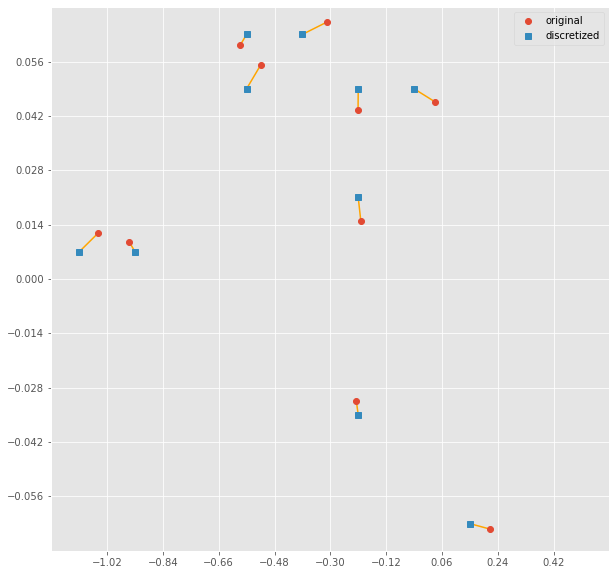

In [11]:
visualize_samples(samples, discretized_samples, state_grid, env.observation_space.low, env.observation_space.high)

## Q-Learning

In [28]:
env = gym.make('MountainCar-v0')
state_grid = create_discretization(env.observation_space.low, env.observation_space.high)

num_episodes = 500
max_step = 1000
env._max_episode_steps = max_step
stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        selector_dist=None)

state_grid = create_discretization(env.observation_space.low, env.observation_space.high)


In [29]:
q_agent = QLearningAgent(action_size=env.action_space.n, state_grid=state_grid, gamma=0.95, alpha=0.1, epsilon=0.1, epsilon_decay_rate=1)

mb = master_bar(range(num_episodes))
max_avg_score = -np.Inf
for episode in mb:
    start = time.time()
    state = env.reset()
    for step in progress_bar(range(max_step), parent=mb):
        
        state = discretize2d(state, state_grid)
        action = q_agent.policy(state)
        next_state, reward, done, _ = env.step(action)
        next_state = discretize2d(next_state, state_grid)
        q_agent.update(state, next_state, action, reward)

        # Update statistics
        stats.episode_rewards[episode] += reward
        stats.episode_lengths[episode] = step

        if done or step > max_step:
            break
        state = next_state

    q_agent.decay_epsilon()

    mb.main_bar.comment = "Episode {}/{}, Reward {}, Total steps {}, Time {:2f}".format(episode, num_episodes, stats.episode_rewards[episode], stats.episode_lengths[episode], time.time()-start)

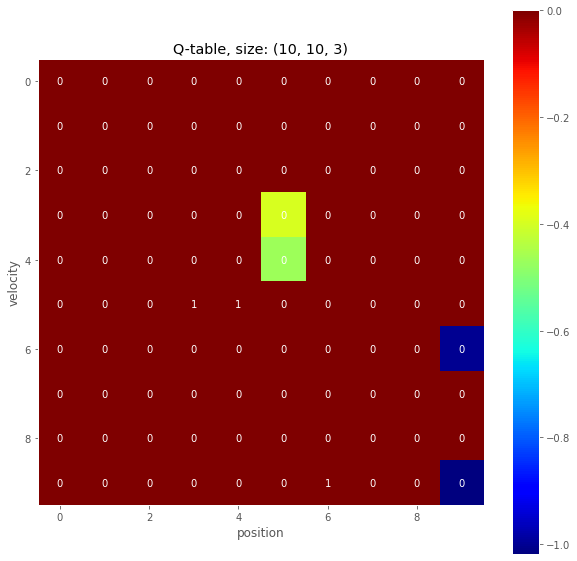

In [38]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet')
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')

plot_q_table(q_agent.Q)

## Con-RL

In [24]:
env = gym.make('MountainCar-v0')
state_grid = create_discretization(env.observation_space.low, env.observation_space.high)

num_episodes = 500
max_step = 1000
env._max_episode_steps = max_step
stats_conrl = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        selector_dist=np.zeros((num_episodes, max_step)))

state_grid = create_discretization(env.observation_space.low, env.observation_space.high)

# Parameters
params = {
    "ndim": 2, 
    "e_w":0.5, 
    "e_n":0.1, 
    "l":10, 
    "a":0.5, 
    "b":0.05, 
    "k":1000.0, 
    "max_nodes":8, 
    "max_age":10
}


In [25]:
conrl = ConRL(action_size=env.action_space.n, state_grid=state_grid, ndim=params["ndim"], update_threshold=3)
conrl.mlgng.set_layers_parameters(params, m=-1)

mb = master_bar(range(num_episodes))
for episode in mb:
    start = time.time()
    state = env.reset()
    for step in progress_bar(range(max_step), parent=mb):

        next_state, reward, done, selected = conrl.step(state, env, discretize=discretize)

        # Update statistics
        stats_conrl.episode_rewards[episode] += reward
        stats_conrl.episode_lengths[episode] = step
        stats_conrl.selector_dist[episode][step] = selected

        if done or step > max_step:
            break
        state = next_state

    mb.main_bar.comment = "Episode {}/{}, Reward {}, Total steps {}, Time {:2f}".format(episode, num_episodes, stats_conrl.episode_rewards[episode], stats_conrl.episode_lengths[episode], time.time()-start)




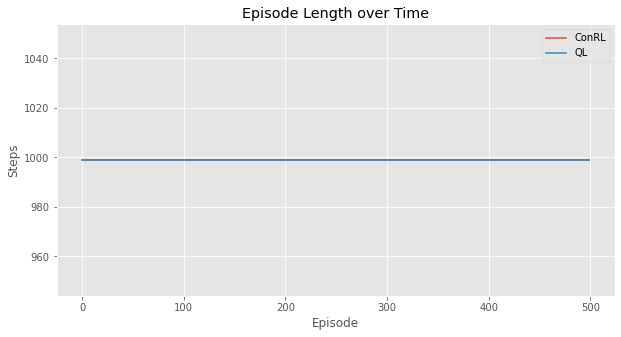

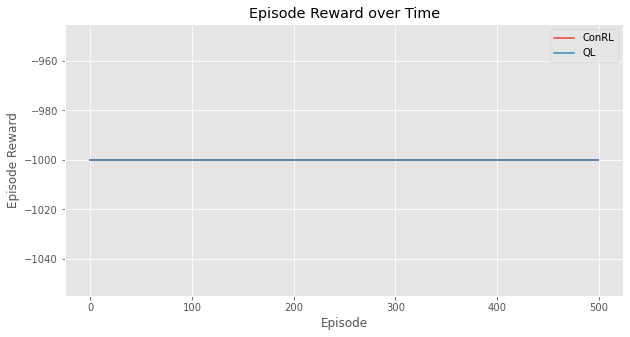

In [31]:
fig1 = plt.figure(figsize=(10,5))
plt.plot(stats_conrl.episode_lengths, label='ConRL')
plt.plot(stats.episode_lengths, label='QL')
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Episode Length over Time")
plt.legend()

fig2 = plt.figure(figsize=(10,5))
plt.plot(stats_conrl.episode_rewards, label='ConRL')
plt.plot(stats.episode_rewards,  label='QL')
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.title("Episode Reward over Time")
plt.legend()

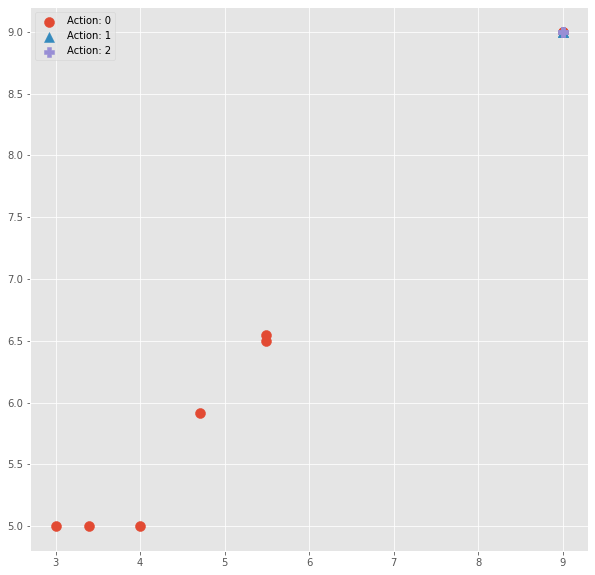

In [32]:
act_dict = {
    0:  "o",
    1: "^",
    2: "P",
}

fig, ax = plt.subplots(figsize=(10, 10))
# Plot discretization as a grid
ax.grid(True)
for i in range(3):
    x, y = conrl.mlgng[i].g.vp.pos.get_2d_array(pos=[0, 1])
    ax.scatter(x, y, label='Action: {}'.format(i), marker=act_dict[i], s=10**2)
    ax.legend()

In [33]:
conrl.mlgng.stats()

> Layer:  0
Iterations:  406055
Graph properties: 
<Graph object, undirected, with 8 vertices and 5 edges, 4 internal vertex properties, 1 internal edge property, at 0x7f3bd1dcbd68>
> Layer:  1
Iterations:  15
Graph properties: 
<Graph object, undirected, with 3 vertices and 3 edges, 4 internal vertex properties, 1 internal edge property, at 0x7f3bd1d66080>
> Layer:  2
Iterations:  23
Graph properties: 
<Graph object, undirected, with 2 vertices and 1 edge, 4 internal vertex properties, 1 internal edge property, at 0x7f3bd1d66358>


Text(0, 0.5, 'Agent')

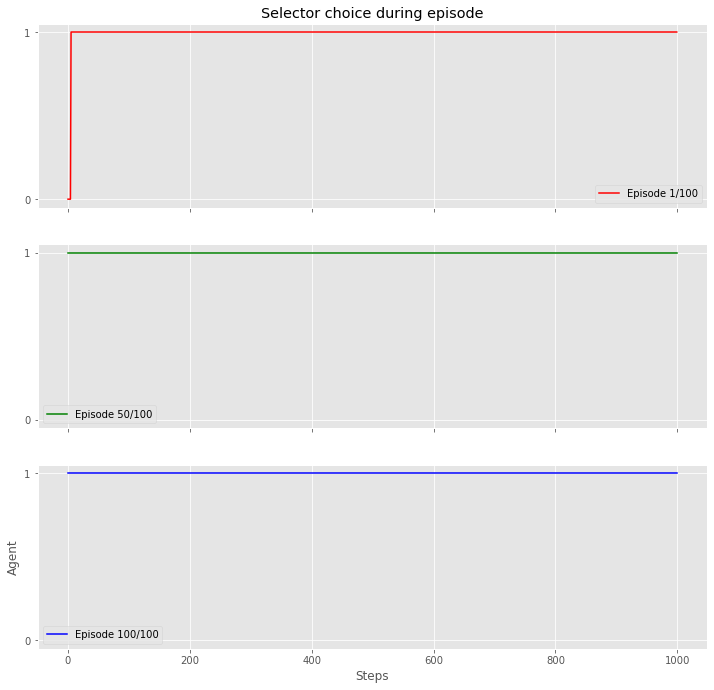

In [34]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(12, 11.5))

ax[0].plot(stats_conrl.selector_dist[0], color="r", label="Episode 1/100")
ax[0].legend()
ax[1].plot(stats_conrl.selector_dist[49], color="g", label="Episode 50/100")

ax[1].legend()
ax[2].plot(stats_conrl.selector_dist[99], color="b", label="Episode 100/100")
ax[2].legend()

ax[0].set_title("Selector choice during episode")
plt.yticks([0, 1])
plt.xlabel("Steps")
plt.ylabel("Agent")



In [42]:
from collections import defaultdict
import itertools

state_actions = defaultdict(lambda: [])

for x, y in list(itertools.product(np.arange(len(state_grid[0])+1), 
                                        np.arange(len(state_grid[1])+1))):
    u = (x, y)
    best_a, _, _, _ = conrl._simple_action_selector(u)
    state_actions[best_a].append(u)


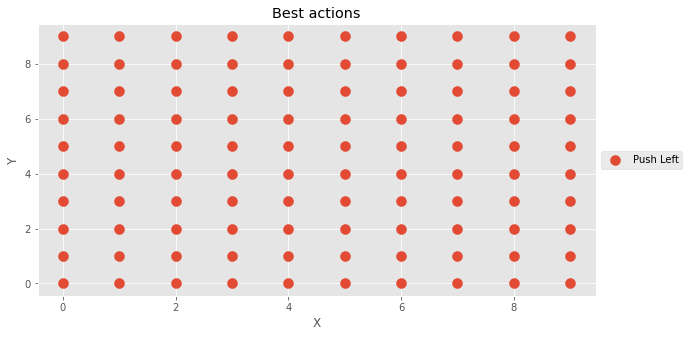

In [43]:
act_dict = {
    0:  "o",
    1: "^",
    2: "P",
}

act_meaning = {
    0: "Left",
    1: "None",
    2: "Right",
}

fig = plt.figure(figsize=(10,5))

for k, v in state_actions.items():
    x, y = zip(*v)
    plt.scatter(x, y, label='Push {}'.format(act_meaning[k]), marker=act_dict[k], s=10**2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Best actions")
